# Red de Cointegración
<a href="https://colab.research.google.com/github/milocortes/mod_04_concentracion/blob/ccm-2023/src/notebooks/python/coint_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stm
from sklearn.linear_model import LinearRegression
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import scipy.stats
import pandas as pd 

class CointegrationNet:
    """docstring for CointegrationNet.
    Parámetros:
        - G (networkx empty Graph):
    """
    def __init__(self, G,diG,name2number_dict,number2name_dict):
        self.G = G
        self.diG = diG
        self.name2number_dict = name2number_dict
        self.number2name_dict = number2name_dict

    def add_nodes(self,N):
        self.G.add_nodes_from([n for n in range(N)])

    def test_unit_root(self,tserie):
        resultados = []
        reg = {'c','ct','nc'}

        for r in reg:
            test_res = stm.adfuller(tserie,maxlag=12,regression=r,autolag= 'AIC')[1]

            if math.isnan(test_res):
                pass
            else:
                if test_res <= 0.05:
                    resultados.append(True)
                else:
                    resultados.append(False)

        if len(resultados)==0:
            return True
        elif any(resultados):
            # Is True we can reject the null hypothesis that there is a unit root
            return True
        else:
            # Is False we can not reject the null hypothesis that there is a unit root
            return False

    def test_eg_cointegration(self,x,y):
        p_value = stm.coint(y,x, return_results=True)[1]

        if p_value < 0.05:
            return True
        else:
            return False

    def test_connection(self,x,y):
        x_np = x.to_numpy()
        y_np = y.to_numpy()

        if not self.test_unit_root(x_np) and not self.test_unit_root(y_np):
            if self.test_eg_cointegration(x_np,y_np):
                print('Cointegran')
                beta,pvalue=linear_reg(x,y)

                if pvalue < 0.05:
                    print("El b1 es significativo")
                    ## Unweighted Graph
                    from_node = self.name2number_dict[x.name]
                    to_node = self.name2number_dict[y.name]
                    self.G.add_edge(from_node,to_node)

                    ## Weighted Graph
                    reg = LinearRegression().fit([[1,x] for x in x_np], y_np)
                    b1 = reg.coef_[1]
                    print("Coint coef: {}".format(b1))
                    self.diG.add_edge(from_node,to_node, weight=b1)


def linear_reg(x,y):

    X = [[1,i] for i in x]
    Y = y

    regress = LinearRegression().fit(X,Y)
    R2 = regress.score(X,Y)
    Y_pred= regress.predict(X)
    MSE = mean_squared_error(Y_pred,Y)

    b0 = regress.intercept_
    b1 = regress.coef_[1]

    n = len(x)
    var_b0= (1/n) * ((MSE*np.square(x).sum())/np.square(x -x.mean()).sum())
    var_b1 = MSE/np.square(x -x.mean()).sum()
    t_b0 = b0/math.sqrt(var_b0)
    t_b1 = b1/math.sqrt(var_b1)

    pvalue_b0 = scipy.stats.t.sf(abs(t_b0),n-2)
    pvalue_b1 = scipy.stats.t.sf(abs(t_b1),n-2)

    return b1,pvalue_b1


## Instalamos la API del Banco Mundial para descargar datos


https://blogs.worldbank.org/opendata/introducing-wbgapi-new-python-package-accessing-world-bank-data

In [2]:
#!pip install wbgapi
import wbgapi as wb


In [3]:
help(wb)  


Help on package wbgapi:

NAME
    wbgapi

DESCRIPTION
    wbgapi provides a comprehensive interface to the World Bank's data and
    metadata API with built-in pandas integration

PACKAGE CONTENTS
    __version__
    data
    economy
    economy_coder
    economy_metadata
    income
    lending
    region
    series
    series_metadata
    source
    time
    topic
    utils

CLASSES
    builtins.Exception(builtins.BaseException)
        APIError
            APIResponseError
        URLError
    builtins.dict(builtins.object)
        Coder
    builtins.object
        Featureset
        Metadata
        MetadataCollection
    
    class APIError(builtins.Exception)
     |  APIError(url, msg, code=None)
     |  
     |  Common base class for all non-exit exceptions.
     |  
     |  Method resolution order:
     |      APIError
     |      builtins.Exception
     |      builtins.BaseException
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(sel

In [4]:
help(wb.series)  

Help on module wbgapi.series in wbgapi:

NAME
    wbgapi.series - Access information about series in a database

FUNCTIONS
    Series(id='all', q=None, topic=None, db=None, name='SeriesName')
        Return a pandas Series by calling list
    
    get(id, db=None)
        Retrieve a specific series object
        
        Arguments:
            id:     the series identifier
        
            db:     database; pass None to access the global database
        
        Returns:
            a series object
        
        Example:
            print(wbgapi.series.get('SP.POP.TOTL')['value'])
    
    info(id='all', q=None, topic=None, db=None)
        Print a user report of series. This can be time consuming
        for large databases like the WDI if 'all' series are requested.
        
        Arguments:
            id:         a series identifier or list-like of identifiers
        
            q:          search string (on series name))
        
            topic:      topic ID or li

In [5]:
wb.source.info()


id,name,code,concepts,lastupdated
1,Doing Business,DBS,3,2021-08-18
2,World Development Indicators,WDI,3,2023-05-10
3,Worldwide Governance Indicators,WGI,3,2022-09-23
5,Subnational Malnutrition Database,SNM,3,2016-03-21
6,International Debt Statistics,IDS,4,2022-12-06
11,Africa Development Indicators,ADI,3,2013-02-22
12,Education Statistics,EDS,3,2020-12-20
13,Enterprise Surveys,ESY,3,2022-03-25
14,Gender Statistics,GDS,3,2023-05-12
15,Global Economic Monitor,GEM,3,2020-07-27


In [6]:
wb.series.info('NY.GDP.PCAP.CD')           # GDP
wb.economy.info(['CAN', 'USA', 'MEX','BRA'])     # Countries in North America

id,value,region,incomeLevel
BRA,Brazil,LCN,UMC
CAN,Canada,NAC,HIC
MEX,Mexico,LCN,UMC
USA,United States,NAC,HIC
,4 elements,,


In [7]:
year_ini = 1980
year_fin = 2010

gdp_countries = wb.data.DataFrame(['NY.GDP.PCAP.CD'], wb.region.members('LCN'), time=range(year_ini, year_fin), skipBlanks=True, columns='series')
gdp_countries_nac = wb.data.DataFrame(['NY.GDP.PCAP.CD'], wb.region.members('NAC'), time=range(year_ini, year_fin), skipBlanks=True, columns='series')

gdp_countries = pd.concat([gdp_countries, gdp_countries_nac])
gdp_countries

NY.GDP.PCAP.CD
economy time                  
ABW     YR1986     6283.001443
        YR1987     7567.253642
        YR1988     9274.514156
        YR1989    10767.396220
        YR1990    11638.733706
...                        ...
USA     YR2005    44123.407068
        YR2006    46302.000880
        YR2007    48050.223777
        YR2008    48570.045980
        YR2009    47194.943355

[1155 rows x 1 columns]

In [8]:
gdp_countries = gdp_countries.reset_index()
gdp_countries

,economy,time,NY.GDP.PCAP.CD
0,ABW,YR1986,6283.001443
1,ABW,YR1987,7567.253642
2,ABW,YR1988,9274.514156
3,ABW,YR1989,10767.396220
4,ABW,YR1990,11638.733706
...,...,...,...
1150,USA,YR2005,44123.407068
1151,USA,YR2006,46302.000880
1152,USA,YR2007,48050.223777
1153,USA,YR2008,48570.045980


In [9]:
gdp_countries["time"] = gdp_countries["time"].apply(lambda x : int(x[2:]))
gdp_countries

,economy,time,NY.GDP.PCAP.CD
0,ABW,1986,6283.001443
1,ABW,1987,7567.253642
2,ABW,1988,9274.514156
3,ABW,1989,10767.396220
4,ABW,1990,11638.733706
...,...,...,...
1150,USA,2005,44123.407068
1151,USA,2006,46302.000880
1152,USA,2007,48050.223777
1153,USA,2008,48570.045980


In [10]:
import pandas as pd 

acumula_paises = []

N = len(range(year_ini, year_fin))

for country in gdp_countries.economy.unique():
    country_df = gdp_countries.query(f"economy == '{country}' and (time >= {year_ini} and time <={year_fin})")
    if country_df.shape[0] == N:
        acumula_paises.append(country_df)
        
        
paises_rango_completo = pd.concat(acumula_paises, ignore_index = True)
paises_rango_completo

,economy,time,NY.GDP.PCAP.CD
0,ARG,1980,2746.207484
1,ARG,1981,2763.375182
2,ARG,1982,2914.918251
3,ARG,1983,3539.456782
4,ARG,1984,2651.229542
...,...,...,...
1105,USA,2005,44123.407068
1106,USA,2006,46302.000880
1107,USA,2007,48050.223777
1108,USA,2008,48570.045980


In [11]:
data = paises_rango_completo.pivot(index='time', columns='economy', values='NY.GDP.PCAP.CD')
data = data.reset_index(drop = True)
data

economy,ARG,ATG,BHS,BLZ,BMU,BOL,BRA,BRB,CAN,CHL,...,PER,PRI,PRY,SLV,SUR,TTO,URY,USA,VCT,VEN
0,2746.207484,2025.474682,5967.767886,1363.840218,11218.217816,791.042223,1941.259538,3992.036338,11170.563972,2531.573261,...,1036.321386,4502.838428,1444.694522,792.629461,2119.367016,5528.946469,3440.717771,12574.791506,766.099178,3886.573956
1,2763.375182,2271.831926,6257.786590,1318.127065,13425.976966,1004.880903,2061.349954,4374.851750,12337.466249,2965.374260,...,1208.125831,4920.722937,1778.053821,755.565946,2365.248670,6118.941041,3724.899679,13976.105393,943.577000,4241.311872
2,2914.918251,2519.803144,6797.830965,1195.508972,14166.171293,933.735307,2118.564108,4552.944471,12481.874787,2144.915565,...,1185.401477,5115.008514,1666.650808,738.969574,2425.203028,7034.945354,3080.980673,14433.787727,1043.911422,4214.671632
3,3539.456782,2784.737233,7324.186554,1231.012451,15902.020383,885.965191,1448.009731,4818.683873,13425.122489,1699.656589,...,920.529713,5217.722729,1696.913066,747.673146,2328.621619,6628.471757,1704.575828,15543.893717,1114.614252,4091.940170
4,2651.229542,3187.981492,8463.464999,1342.227691,17469.825568,986.812952,1406.689800,5235.134119,13877.917076,1615.320908,...,911.789224,5730.117009,1309.658013,765.687100,2258.132806,6547.459781,1612.310606,17121.225485,1223.839496,3539.754463
5,2919.283585,3703.786816,9436.232744,1301.082642,18269.535520,842.090233,1287.612405,5465.203582,14114.807760,1436.176916,...,838.059141,6008.054486,928.426274,779.281929,2254.817639,6147.700102,1564.707926,18236.827727,1313.199513,3560.762222
6,3607.820561,4488.196018,9858.295721,1385.471231,20450.664529,607.082140,1545.928425,5990.460128,14461.069239,1509.532606,...,754.349926,6455.184461,1024.193149,758.765652,2270.804237,3941.600372,1933.481231,19071.227195,1444.021409,3381.223769
7,3559.218959,5239.458329,10617.405269,1643.949927,22411.795675,652.705759,1667.187570,6589.383144,16308.966966,1750.632095,...,1001.496679,6980.490143,1062.046435,781.111028,2469.341114,3896.064758,2408.632599,20038.941099,1570.910328,2620.434204
8,3982.444402,6230.466815,10819.268042,1831.019639,24253.175519,675.715310,1781.817876,7005.502809,18936.964102,2015.749007,...,730.209763,7595.444656,1106.971847,810.352697,2887.061439,3612.994412,2668.666647,21417.011931,1790.987478,3203.401445
9,2382.560951,6895.386079,11533.260764,2065.720309,25517.921721,678.642159,2344.730687,7753.025660,20715.631483,2276.376909,...,1040.475190,8033.089441,1204.096538,829.512515,1328.729552,3441.350430,2724.097434,22857.154433,1911.903510,2258.137184


In [12]:

# Generamos una instancia de la clase CointegrationNet
G = nx.Graph()
diG = nx.DiGraph()

names2number_dict = {k:v for k,v in zip(data.columns,range(len(data.columns)))}
number2name_dict = {v:k for k,v in zip(data.columns,range(len(data.columns)))}

coint_net = CointegrationNet(G,diG, names2number_dict,number2name_dict)


In [13]:
paises_ejecucion = data.columns.to_list()
paises_ejecucion

['ARG',
 'ATG',
 'BHS',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'CAN',
 'CHL',
 'COL',
 'CRI',
 'CUB',
 'DMA',
 'DOM',
 'ECU',
 'GRD',
 'GTM',
 'GUY',
 'HND',
 'HTI',
 'JAM',
 'KNA',
 'LCA',
 'MEX',
 'NIC',
 'PAN',
 'PER',
 'PRI',
 'PRY',
 'SLV',
 'SUR',
 'TTO',
 'URY',
 'USA',
 'VCT',
 'VEN']

In [14]:
from tqdm import tqdm

for variable in tqdm(paises_ejecucion):

     print('Variable : {}, número: {}'.format(variable,coint_net.name2number_dict[variable]))

     variables = set(paises_ejecucion)

     variables.remove(variable)

     for var in variables:
         coint_net.test_connection(data[variable],data[var])

  0%|          | 0/37 [00:00<?, ?it/s]

Variable : ARG, número: 0


  3%|▎         | 1/37 [00:01<00:37,  1.05s/it]

Variable : ATG, número: 1
Cointegran
El b1 es significativo
Coint coef: 0.5158843094907652


  5%|▌         | 2/37 [00:02<00:35,  1.02s/it]

Variable : BHS, número: 2
Cointegran
El b1 es significativo
Coint coef: 0.05295348151973846
Cointegran
El b1 es significativo
Coint coef: 0.1740371924039423
Cointegran
El b1 es significativo
Coint coef: 0.11288107538257407
Cointegran
El b1 es significativo
Coint coef: 0.21020246572058646
Cointegran
El b1 es significativo
Coint coef: 0.27107432413799604
Cointegran
El b1 es significativo
Coint coef: 0.2253369237076921
Cointegran
El b1 es significativo
Coint coef: 0.4359148171757121


  8%|▊         | 3/37 [00:02<00:34,  1.00s/it]

Variable : BLZ, número: 3
Cointegran
El b1 es significativo
Coint coef: 1.0085327051456139


 11%|█         | 4/37 [00:03<00:32,  1.01it/s]

Variable : BMU, número: 4
Cointegran
El b1 es significativo
Coint coef: 0.062057534165224595
Cointegran
El b1 es significativo
Coint coef: 0.03885281732353175
Cointegran
El b1 es significativo
Coint coef: 0.2290499692398206
Cointegran
El b1 es significativo
Coint coef: 0.09094585881084251


 14%|█▎        | 5/37 [00:04<00:32,  1.00s/it]

Variable : BOL, número: 5
Cointegran
El b1 es significativo
Coint coef: 13.595106498150155
Cointegran
El b1 es significativo
Coint coef: 8.365904478063042
Cointegran
El b1 es significativo
Coint coef: 2.733362212124059


 16%|█▌        | 6/37 [00:05<00:31,  1.01s/it]

Variable : BRA, número: 6


 19%|█▉        | 7/37 [00:06<00:30,  1.01s/it]

Variable : BRB, número: 7
Cointegran
El b1 es significativo
Coint coef: 0.4513035439334446
Cointegran
El b1 es significativo
Coint coef: 1.7006329759243404
Cointegran
El b1 es significativo
Coint coef: 0.6618835492388565


 22%|██▏       | 8/37 [00:07<00:29,  1.01s/it]

Cointegran
El b1 es significativo
Coint coef: 0.4477447101115388
Variable : CAN, número: 8


 24%|██▍       | 9/37 [00:08<00:23,  1.20it/s]

Variable : CHL, número: 9
Cointegran
El b1 es significativo
Coint coef: 0.4556422081713538
Cointegran
El b1 es significativo
Coint coef: 2.252704798469511
Cointegran
El b1 es significativo
Coint coef: 1.225537524381902
Cointegran
El b1 es significativo
Coint coef: 1.4932820374019675
Cointegran
El b1 es significativo
Coint coef: 0.7015504896116971


 27%|██▋       | 10/37 [00:09<00:23,  1.13it/s]

Cointegran
El b1 es significativo
Coint coef: 0.6023326176077228
Variable : COL, número: 10


 30%|██▉       | 11/37 [00:10<00:23,  1.08it/s]

Variable : CRI, número: 11


 32%|███▏      | 12/37 [00:10<00:19,  1.28it/s]

Variable : CUB, número: 12


 35%|███▌      | 13/37 [00:11<00:19,  1.20it/s]

Cointegran
El b1 es significativo
Coint coef: 0.7443805711435885
Variable : DMA, número: 13
Cointegran
El b1 es significativo
Coint coef: 1.4273652874885085


 38%|███▊      | 14/37 [00:12<00:20,  1.14it/s]

Cointegran
El b1 es significativo
Coint coef: 1.3352732382336876
Variable : DOM, número: 14
Cointegran
El b1 es significativo
Coint coef: 0.4104886736414784
Cointegran
El b1 es significativo
Coint coef: 2.7549814579349565


 41%|████      | 15/37 [00:13<00:20,  1.10it/s]

Cointegran
El b1 es significativo
Coint coef: 0.6228524892460459
Variable : ECU, número: 15
Cointegran
El b1 es significativo
Coint coef: 1.4725133403927888
Cointegran
El b1 es significativo
Coint coef: 1.2063310190774363


 43%|████▎     | 16/37 [00:14<00:19,  1.08it/s]

Cointegran
El b1 es significativo
Coint coef: 0.9501350229812681
Variable : GRD, número: 16
Cointegran
El b1 es significativo
Coint coef: 5.931499930480744
Cointegran
El b1 es significativo
Coint coef: 0.9151737335331732
Cointegran
El b1 es significativo
Coint coef: 2.3020771787131307
Cointegran
El b1 es significativo
Coint coef: 1.3608382431451174


 46%|████▌     | 17/37 [00:15<00:18,  1.06it/s]

Cointegran
El b1 es significativo
Coint coef: 1.2844467482400128
Variable : GTM, número: 17
Cointegran
El b1 es significativo
Coint coef: 0.43992252182733255
Cointegran
El b1 es significativo
Coint coef: 2.2962520059910694


 49%|████▊     | 18/37 [00:16<00:17,  1.06it/s]

Variable : GUY, número: 18


 51%|█████▏    | 19/37 [00:17<00:16,  1.06it/s]

Variable : HND, número: 19


 54%|█████▍    | 20/37 [00:18<00:15,  1.06it/s]

Variable : HTI, número: 20


 57%|█████▋    | 21/37 [00:19<00:15,  1.06it/s]

Cointegran
El b1 es significativo
Coint coef: 0.7890314050748588
Variable : JAM, número: 21


 59%|█████▉    | 22/37 [00:19<00:11,  1.28it/s]

Variable : KNA, número: 22
Cointegran
El b1 es significativo
Coint coef: 0.41938262669385307
Cointegran
El b1 es significativo
Coint coef: 0.42370312028089824
Cointegran
El b1 es significativo
Coint coef: 0.6020330745857371


 62%|██████▏   | 23/37 [00:20<00:11,  1.20it/s]

Variable : LCA, número: 23
Cointegran
El b1 es significativo
Coint coef: 1.9158957886365129


 65%|██████▍   | 24/37 [00:21<00:11,  1.14it/s]

Variable : MEX, número: 24
Cointegran
El b1 es significativo
Coint coef: 4.13476776271669
Cointegran
El b1 es significativo
Coint coef: 0.6947323337948432
Cointegran
El b1 es significativo
Coint coef: 1.480005364141304
Cointegran
El b1 es significativo
Coint coef: 2.5318920583045244


 68%|██████▊   | 25/37 [00:22<00:10,  1.10it/s]

Cointegran
El b1 es significativo
Coint coef: 0.28349415006523415
Variable : NIC, número: 25
Cointegran
El b1 es significativo
Coint coef: 3.0397672264515156
Cointegran
El b1 es significativo
Coint coef: 8.588702157688145


 70%|███████   | 26/37 [00:23<00:10,  1.07it/s]

Variable : PAN, número: 26
Cointegran
El b1 es significativo
Coint coef: 1.3969227307352359
Cointegran
El b1 es significativo
Coint coef: 1.952122409357685


 73%|███████▎  | 27/37 [00:24<00:09,  1.05it/s]

Cointegran
El b1 es significativo
Coint coef: 0.5117940743433778
Variable : PER, número: 27


 76%|███████▌  | 28/37 [00:25<00:07,  1.26it/s]

Variable : PRI, número: 28
Cointegran
El b1 es significativo
Coint coef: 0.24997176014887323
Cointegran
El b1 es significativo
Coint coef: 4.21793097851047
Cointegran
El b1 es significativo
Coint coef: 0.3754499175450536
Cointegran
El b1 es significativo
Coint coef: 0.569394993147683
Cointegran
El b1 es significativo
Coint coef: 0.02845839233422614
Cointegran
El b1 es significativo
Coint coef: 0.3561679033999547


 78%|███████▊  | 29/37 [00:26<00:06,  1.18it/s]

Cointegran
El b1 es significativo
Coint coef: 0.2589720656049252
Variable : PRY, número: 29


 81%|████████  | 30/37 [00:26<00:05,  1.39it/s]

Variable : SLV, número: 30
Cointegran
El b1 es significativo
Coint coef: 2.369164256912063
Cointegran
El b1 es significativo
Coint coef: 3.4753291540817477


 84%|████████▍ | 31/37 [00:27<00:04,  1.27it/s]

Cointegran
El b1 es significativo
Coint coef: 3.21932755410723
Variable : SUR, número: 31
Cointegran
El b1 es significativo
Coint coef: 1.394651255141885


 86%|████████▋ | 32/37 [00:28<00:04,  1.19it/s]

Variable : TTO, número: 32


 89%|████████▉ | 33/37 [00:29<00:03,  1.14it/s]

Variable : URY, número: 33


 92%|█████████▏| 34/37 [00:29<00:02,  1.35it/s]

Variable : USA, número: 34
Cointegran
El b1 es significativo
Coint coef: 0.15186177746851623
Cointegran
El b1 es significativo
Coint coef: 0.16699162737676554
Cointegran
El b1 es significativo
Coint coef: 0.22657577639243628


 95%|█████████▍| 35/37 [00:30<00:01,  1.24it/s]

Cointegran
El b1 es significativo
Coint coef: 0.215218638947615
Variable : VCT, número: 35
Cointegran
El b1 es significativo
Coint coef: 0.9976785778705065
Cointegran
El b1 es significativo
Coint coef: 1.4755290128787906
Cointegran
El b1 es significativo
Coint coef: 2.203419324352591


 97%|█████████▋| 36/37 [00:31<00:00,  1.17it/s]

Variable : VEN, número: 36
Cointegran
El b1 es significativo
Coint coef: 1.6021576026689963
Cointegran
El b1 es significativo
Coint coef: 0.43710763119148804


100%|██████████| 37/37 [00:32<00:00,  1.13it/s]

Cointegran
El b1 es significativo
Coint coef: 0.2422941416467285
Cointegran
El b1 es significativo
Coint coef: 0.10869367872181965


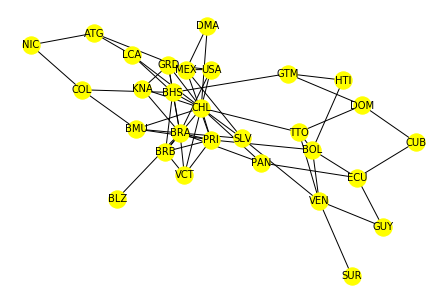

In [15]:
#### Renombramos los nodos
renombra_G = {nodo:number2name_dict[nodo] for nodo in coint_net.G}

G_plot = nx.relabel_nodes(coint_net.G, renombra_G)

#### Graficamos la red no dirigida
pos = nx.layout.spring_layout(G_plot)
nx.draw(G_plot,pos,node_color="yellow")
# Draw node labels
for n in G_plot.nodes():
    plt.annotate(n,
        xy = pos[n],
        textcoords = 'offset points',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        xytext = [0, 0], color ="black")


plt.axis('off')
plt.show()

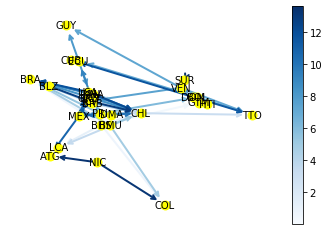

In [16]:
#### Graficamos la red dirigida
import matplotlib as mpl

#### Renombramos los nodos
renombra_diG = {nodo:number2name_dict[nodo] for nodo in coint_net.diG}

diG_plot = nx.relabel_nodes(coint_net.diG, renombra_diG)

pos = nx.layout.spring_layout(diG_plot)
edges,weights = zip(*nx.get_edge_attributes(diG_plot,'weight').items())

M = diG_plot.number_of_edges()
edge_colors = np.linspace(min(weights),max(weights),M)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(diG_plot, pos, node_color="yellow",node_size=80)
edges = nx.draw_networkx_edges(
    diG_plot,
    pos,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
)
for n in diG_plot.nodes():
    plt.annotate(n,
        xy = pos[n],
        textcoords = 'offset points',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        xytext = [0, 0], color ="black")

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [17]:

#### Obtenemos medidas de centralidad
medidas_centralidad = {}

# Degree Centrality
medidas_centralidad['degree_cent'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.degree_centrality(coint_net.G).items(), key=lambda x: x[1])).items()}
medidas_centralidad['in_degree_cent'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.in_degree_centrality(coint_net.diG).items(), key=lambda x: x[1])).items()}
medidas_centralidad['out_degree_cent'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.out_degree_centrality(coint_net.diG).items(), key=lambda x: x[1])).items()}

# Eigenvector Centrality
medidas_centralidad['eigen_cent'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.eigenvector_centrality(coint_net.G).items(), key=lambda x: x[1])).items()}
medidas_centralidad['dig_eigen_cent'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.eigenvector_centrality_numpy(coint_net.diG).items(), key=lambda x: x[1])).items()}

# PageRank
medidas_centralidad['pagerank'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.pagerank_numpy(coint_net.diG, alpha = 0.85).items(), key=lambda x: x[1])).items()}

# Hubs and Authorities
h,a = nx.hits(coint_net.diG)

medidas_centralidad['hubs'] = {number2name_dict[k]:v for k,v in dict(sorted(h.items(), key=lambda x: x[1])).items()}
medidas_centralidad['authorities'] = {number2name_dict[k]:v for k,v in dict(sorted(a.items(), key=lambda x: x[1])).items()}

# Closeness Centrality
medidas_centralidad['closeness_centrality'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.closeness_centrality(coint_net.G).items(), key=lambda x: x[1])).items()}

# Betweenness Centrality
medidas_centralidad['betweenness_centrality'] = {number2name_dict[k]:v for k,v in dict(sorted(nx.betweenness_centrality(coint_net.G).items(), key=lambda x: x[1])).items()}


In [18]:
medidas_centralidad

{'degree_cent': {'BLZ': 0.03571428571428571,
  'SUR': 0.03571428571428571,
  'CUB': 0.07142857142857142,
  'DMA': 0.07142857142857142,
  'GUY': 0.07142857142857142,
  'HTI': 0.07142857142857142,
  'NIC': 0.07142857142857142,
  'ATG': 0.10714285714285714,
  'LCA': 0.10714285714285714,
  'GTM': 0.10714285714285714,
  'COL': 0.10714285714285714,
  'PAN': 0.10714285714285714,
  'KNA': 0.10714285714285714,
  'DOM': 0.10714285714285714,
  'BMU': 0.14285714285714285,
  'TTO': 0.14285714285714285,
  'ECU': 0.14285714285714285,
  'VCT': 0.14285714285714285,
  'USA': 0.14285714285714285,
  'SLV': 0.14285714285714285,
  'BRB': 0.17857142857142855,
  'BOL': 0.17857142857142855,
  'VEN': 0.17857142857142855,
  'GRD': 0.21428571428571427,
  'MEX': 0.21428571428571427,
  'BHS': 0.25,
  'PRI': 0.25,
  'BRA': 0.39285714285714285,
  'CHL': 0.46428571428571425},
 'in_degree_cent': {'BHS': 0.0,
  'BLZ': 0.0,
  'DMA': 0.0,
  'NIC': 0.0,
  'SUR': 0.0,
  'BMU': 0.03571428571428571,
  'DOM': 0.035714285714285

In [19]:
#!pip install infomap

import infomap


def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapX = infomap.Infomap("--two-level")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        infomapX.network.addLink(*e)

    print("Find communities with Infomap...")
    infomapX.run();

    print("Found {} modules with codelength: {}".format(infomapX.numTopModules(), infomapX.codelength))

    communities = {}
    for node in infomapX.iterLeafNodes():
        communities[node.physicalId] = node.moduleIndex()

    print('NUMERO DE NODOS {}'.format(len(communities)))
    nx.set_node_attributes(G, values=communities, name='community')



def drawNetwork(G):

    #pos = nx.circular_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = mcolors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6','#ffffff'], 'indexed', numCommunities)
    cmapDark = mcolors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a','#000000'], 'indexed', numCommunities)



    renombra_G = {nodo:number2name_dict[nodo] for nodo in G}

    G = nx.relabel_nodes(G, renombra_diG)

    # position map
    pos = nx.spring_layout(G)
    # Draw edges
    nx.draw_networkx_edges(G, pos)
    
    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[list(G.nodes()).index(n)])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 2 modules with codelength: 4.282453296520665
NUMERO DE NODOS 29


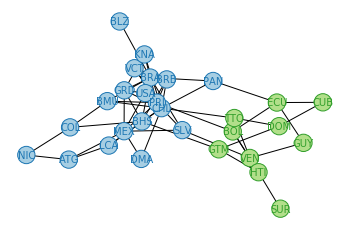

In [20]:
#### Se calculan y grafican las comunidades obtenidas por infomap


findCommunities(coint_net.G)
drawNetwork(coint_net.G)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 4 modules with codelength: 4.202169424940651
NUMERO DE NODOS 29


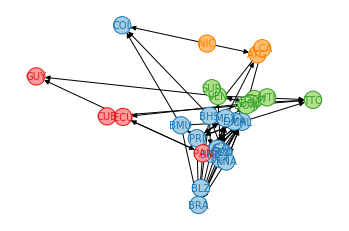

In [21]:
findCommunities(coint_net.diG)
drawNetwork(coint_net.diG)